<a href="https://colab.research.google.com/github/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_3b_data-driven_width_pruning_llama3.2-1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
    <h1>Large Language Models Projects</a></h1>
    <h3>Apply and Implement Strategies for Large Language Models</h3>
    <h2>Data-Driven Width Pruning Llama 3.2.</h2>
    <h3>How to decide with neurons to remove from GLU Structure.</h3>
</div>

by [Pere Martra](https://www.linkedin.com/in/pere-martra/)

_______
Models: meta-llama/Llama-3.2-1B

Colab Environment: GPU T4.

Keys:
* Pruning
* Structured pruning


Related article: [How to Prune LLaMA 3.2 and Similar Large Language Models](ttps://medium.com/towards-data-science/how-to-prune-llama-3-2-and-similar-large-language-models-cf18e9a2afb6.)
_______
<table style="border: none; background: none;">
  <tr style="border: none;">
    <td style="border: none; vertical-align: middle; width: 120px;">
      <a href="https://hubs.la/Q040tvsK0">
        <img src="https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/Images/cover.png" width="110" style="border-radius: 4px;">
      </a>
    </td>
    <td style="border: none; vertical-align: middle;">
      <h2 style="margin: 0;">🚀 The Evolution of LLM Pruning</h2>
      <p style="margin: 5px 0;">Whant to know more? check <strong>"Rearchitecting LLMs"</strong> (Manning Publications).</p>
      <p>
        🔥 <strong>Special Launch Offer: 50% OFF</strong> until February 12.<br>
        👉 <a href="https://hubs.la/Q040tvsK0"><strong>Claim your discount & Check the MEAP</strong></a>
      </p>
    </td>
  </tr>
</table>
______

# Introduction
This notebook cotinues the work done at: [6_2_pruning_structured_llama3.2-1b_KO.ipynb](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_3_pruning_structured_llama3.2-1b_OK.ipynb) where statics methods has beeen used to select the neurons to prune.


#Install libraries & Configure variables.

In [7]:
!pip install -q transformers
!pip install -q torch
!pip install -q datasets
#!pip install -q sentencepiece

In [8]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch import nn
from torch.utils.data import DataLoader
import os, gc
from tqdm import tqdm

In [9]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#Download model and explore structure

In [ ]:
model_name = 'meta-llama/Llama-3.2-1B'
model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.float16).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set pad token

In [11]:
def get_output(prompt, model=model, tokenizer=tokenizer):
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    outputs = model.generate(
        inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=50,
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id,
        temperature=None,
        top_p=None,
        do_sample=False,          # Disable sampling
        num_beams=5,              # Use beam search
        early_stopping=True,      # Stop when end-of-sequence token is generated
        no_repeat_ngram_size=2    # Prevent repetition of 2-grams
    )
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated

## studying the model structure
As demonstrated in the [previous notebook](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_2_pruning_structured_llama3.2-1b_KO.ipynb), studying the structure of the model that will undergo pruning is crucial.

In this notebook we improve the width pruning process that could be seen in the Notebook: [Pruning Llama 3.2.](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_3_pruning_structured_llama3.2-1b_OK.ipynb). Where a pruning of the model's GLU structure was performed taking into account its static weights.

Here we expand the criterion also using the activations of one of the cpas of the GLU, so the pruning that is performed is considered data-drive.

In [12]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro


An MLP block typically consists of layers that scale the data to larger dimensions and others that return it to its original size.

In the MLP block of the model, we find two projection layers: `gate_proj` and `up_proj`, both scaling from 2048 to 8192. The purpose of having two layers projecting to the same intermediate size might be related to gating mechanisms. A gating mechanism selectively controls information flow in neural networks by using learned weights to "gate" or filter inputs.

Also highlight the role the `down_proj` layer plays contracting the information back, after passing through an activation function, to its original size.

However, to truly understand how these layers function, we’d need to refer to the model's documentation or even the source code. But, this structure usually indicates, at least, I haven't encountered a case where it doesn't, that the layers performing the upsizing work in pairs, and they cannot be treated as independent linear layers.

In other words, any operation we apply to one layer must be replicated in the other. Most importantly, when identifying which neurons have more or less importance, we can't evaluate the neurons of a single layer in isolation; we need to treat them as pairs.

For our data-driven pruning process the evaluation we will do will be:
* `gate_proj`: Static with the magnitude of its weights.
* `up_proj`: Static with the magnitude of its weights.
* `down_proj`: Dynamic with activations + Static with the magnitude of its weights.

In [13]:
# Test the original model
prompt = "Paris is the capital of"
generated = get_output(prompt)
print(f"Generated text: {generated}")

Generated text: Paris is the capital of France and one of the most visited cities in the world. It is a city with a rich history and culture, as well as a vibrant and diverse population. Paris is home to many famous landmarks, including the Eiff


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [15]:
original_param_count = count_parameters(model)
print(f"Original model parameters: {original_param_count}")

Original model parameters: 1235814400


## Load Dataset

In [16]:
RECOVERY_SAMPLES = 1000
BATCH_SIZE = 8
MAX_LENGTH = 1024

We're going to use a generic dataset like wikitext, but data-driven pruning shines when the dataset to use is specific to our model. That is, when we want to specialize it in a specific domain.

In [ ]:
datawiki = load_dataset('wikitext', 'wikitext-2-raw-v1', split=f'train[:{RECOVERY_SAMPLES}]')


In [18]:
def prepare_dataset(dataset, text_field='text'):
  def tokenize_function(examples):
      if text_field in examples:
          texts = examples[text_field]
      elif 'sms' in examples:  # SMS dataset
          texts = examples['sms']
      elif 'text' in examples:
          texts = examples['text']
      else:
          texts = examples[list(examples.keys())[0]]  # First available field

      return tokenizer(
          texts,
          truncation=True,
          padding='max_length',
          max_length=MAX_LENGTH,
          return_tensors='pt'
      )

  tokenized = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)
  tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask'])
  return DataLoader(tokenized, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Create dataloader
dataloaderwiki = prepare_dataset(datawiki)

## Hooks

To be able to analyze the activations that occur in a layer, we need a mechanism that lets us "spy" on what happens inside the model.

This mechanism is PyTorch Hooks, which let us hook a function to any module of the model and its input and output activations.

In [20]:
# Variable global para acumular normas
_accumulated_act_norms = {}

def setup_mlp_hooks_for_importance(model, device):
    """
    Registra hooks en la entrada de down_proj (X_d) para calcular
    la Norma L2 de cada neurona (||X_d^i||), según CFSP Ecuación 8.

    Acumula las normas L2 a través de múltiples batches de calibración.

    Returns:
        handles: Lista de handles de hooks (para remover después)
    """
    global _accumulated_act_norms
    _accumulated_act_norms.clear()

    # Liberar memoria antes de empezar
    gc.collect()
    torch.cuda.empty_cache()

    handles = []

    # Inicializar almacenamiento en CPU (ahorro de VRAM)
    for idx, layer in enumerate(model.model.layers):
        intermediate_size = layer.mlp.down_proj.in_features
        _accumulated_act_norms[idx] = torch.zeros(
            intermediate_size,
            dtype=torch.float32,  # Explícito para consistencia
            device='cpu'
        )

    def make_hook(layer_idx):
        def hook(module, input, output):
            """
            Captura X_d (entrada a down_proj) y calcula su Norma L2.

            X_d shape: [batch_size, seq_len, intermediate_size]
            Output: [intermediate_size] con ||X_d^i|| para cada neurona i
            """
            X_d = input[0].detach()  # [B, S, I]

            # --- CÁLCULO NORMA L2 (Ecuación 8 del paper) ---
            # torch.norm con p=2 y dim=(0,1) hace:
            # ||X_d^i|| = sqrt(sum_{b,s} X_d[b,s,i]²)
            act_norms_L2 = torch.norm(
                X_d.to(torch.float32),  # Asegurar precisión
                p=2,
                dim=(0, 1)  # Sumar sobre batch y secuencia
            )  # Resultado: [intermediate_size]

            # Acumular en CPU para ahorrar VRAM
            _accumulated_act_norms[layer_idx] += act_norms_L2.cpu()

        return hook

    # Registrar hooks
    for idx, layer in enumerate(model.model.layers):
        handle = layer.mlp.down_proj.register_forward_hook(
            make_hook(idx)
        )
        handles.append(handle)

    print(f"✓ Registrados {len(handles)} hooks en down_proj para capturar X_d")

    return handles

In [21]:
def get_activation_norms():
    """
    Retorna las normas L2 acumuladas en formato listo para usar.

    Returns:
        Dict[int, torch.Tensor]: {layer_idx: normas_L2 [intermediate_size]}
    """
    return {
        layer_idx: norms.clone()  # Clone para evitar modificaciones
        for layer_idx, norms in _accumulated_act_norms.items()
    }

#Pruning the Model.
##Support pruning functions.
###Compute neuron importance functions.





In [22]:
def compute_neuron_pair_importance(gate_weight, up_weight, down_weight, X_d_norm):
    """
    Computes neuron pair importance scores using CFSP methodology (Equation 8).

    Paper: "CFSP: An Efficient Structured Pruning Framework for LLMs with
            Coarse-to-Fine Activation Information" (arXiv:2409.13199v2)

    Equation 8:
    F_i^l = Σ_j ( |W_d^ij · ||X_d^i|| / ||W_d^*j · ||X_d^*||| + |W_u^ij| / ||W_u^i*|| + |W_g^ij| / ||W_g^i*|| )

    Where:
    - W_d: down_proj weights [hidden_size, intermediate_size]
    - W_u: up_proj weights [intermediate_size, hidden_size]
    - W_g: gate_proj weights [intermediate_size, hidden_size]
    - X_d: Activations at down_proj input (SiLU(gate) ⊙ up)
    - ||X_d^i||: L2 norm of neuron i across batch and sequence
    - W_d^*j: Σ_i |W_d^ij| (sum of weight magnitudes in column j)
    - ||X_d^*||: Σ_i ||X_d^i|| (sum of all activation norms)

    Args:
        gate_weight: Tensor [intermediate_size, hidden_size] from gate_proj.weight
        up_weight: Tensor [intermediate_size, hidden_size] from up_proj.weight
        down_weight: Tensor [hidden_size, intermediate_size] from down_proj.weight
        X_d_norm: Tensor [intermediate_size] with accumulated L2 norms ||X_d^i||

    Returns:
        importance_scores: Tensor [intermediate_size] with importance score per neuron pair
    """
    device = gate_weight.device
    intermediate_size = gate_weight.size(0)

    # Move X_d_norm to same device and ensure float32
    X_d_norm = X_d_norm.to(device).to(torch.float32)

    # Convert weights to float32 for numerical stability
    gate_weight = gate_weight.float()
    up_weight = up_weight.float()
    down_weight = down_weight.float()

    # ============================================================================
    # COMPONENT 1: down_proj with activations
    # Term: |W_d^ij · ||X_d^i|| / (||W_d^*j|| · ||X_d^*||)
    # ============================================================================

    # Transpose down_weight: [hidden_size, intermediate_size] -> [intermediate_size, hidden_size]
    W_d_t = down_weight.t()  # [intermediate_size, hidden_size]
    W_d_abs = torch.abs(W_d_t)  # [intermediate_size, hidden_size]

    # --- NUMERATOR: |W_d^ij| * ||X_d^i|| ---
    # Element-wise product for each (i, j) pair
    numerator = W_d_abs * X_d_norm.unsqueeze(1)  # [intermediate_size, hidden_size]

    # --- DENOMINATOR: (Σ_i |W_d^ij|) * (Σ_i ||X_d^i||) ---
    # Part 1: ||W_d^*j|| = Σ_i |W_d^ij| (sum over rows for each column j)
    W_d_column_sums = W_d_abs.sum(dim=0, keepdim=True)  # [1, hidden_size]

    # Part 2: ||X_d^*|| = Σ_i ||X_d^i|| (sum of all activation norms)
    X_d_total_norm = X_d_norm.sum()  # Scalar

    # Denominator: product of the two sums (broadcast to match numerator shape)
    denominator = W_d_column_sums * X_d_total_norm  # [1, hidden_size]

    # --- NORMALIZED TERM ---
    # Divide numerator by denominator and sum over output dimension j
    normalized_down = (numerator / (denominator + 1e-8)).sum(dim=1)  # [intermediate_size]

    # ============================================================================
    # COMPONENT 2: up_proj weights only
    # Term: |W_u^ij| / ||W_u^i*||
    # ============================================================================

    # Take absolute values of up_proj weights
    up_abs = torch.abs(up_weight)  # [intermediate_size, hidden_size]

    # Sum over input dimension (rows): ||W_u^i*||
    row_sums_up = up_abs.sum(dim=1, keepdim=True)  # [intermediate_size, 1]

    # Normalize by row sum and sum over output dimension
    normalized_up = (up_abs / (row_sums_up + 1e-8)).sum(dim=1)  # [intermediate_size]

    # ============================================================================
    # COMPONENT 3: gate_proj weights only
    # Term: |W_g^ij| / ||W_g^i*||
    # ============================================================================

    # Take absolute values of gate_proj weights
    gate_abs = torch.abs(gate_weight)  # [intermediate_size, hidden_size]

    # Sum over input dimension (rows): ||W_g^i*||
    row_sums_gate = gate_abs.sum(dim=1, keepdim=True)  # [intermediate_size, 1]

    # Normalize by row sum and sum over output dimension
    normalized_gate = (gate_abs / (row_sums_gate + 1e-8)).sum(dim=1)  # [intermediate_size]

    # ============================================================================
    # FINAL IMPORTANCE SCORE (Equation 8)
    # F_i^l = sum of all three components
    # ============================================================================

    importance_scores = normalized_down + normalized_up + normalized_gate

    return importance_scores

In [23]:
def prune_neuron_pairs(mlp, prune_percent, X_d_norm, layer_idx):
    """
    Prunes neuron pairs from MLP block using CFSP importance scores.

    Reduces dimensions of gate_proj, up_proj, and down_proj layers by removing
    the least important neuron pairs based on data-driven activation analysis.

    Args:
        mlp: LlamaMLP module to prune
        prune_percent: Fraction of neurons to remove (e.g., 0.2 for 20%)
        X_d_norm: Tensor [intermediate_size] with accumulated L2 norms ||X_d^i||
                  from calibration forward passes
        layer_idx: Layer index (for logging/debugging purposes)

    Returns:
        new_gate_proj: Pruned gate_proj layer
        new_up_proj: Pruned up_proj layer
        new_down_proj: Pruned down_proj layer
        k: New intermediate size after pruning
    """

    # ============================================================================
    # STEP 1: Extract weights from original layers
    # ============================================================================

    gate_weight = mlp.gate_proj.weight.data  # [intermediate_size, hidden_size]
    up_weight = mlp.up_proj.weight.data      # [intermediate_size, hidden_size]
    down_weight = mlp.down_proj.weight.data  # [hidden_size, intermediate_size]

    original_intermediate_size = gate_weight.size(0)

    # ============================================================================
    # STEP 2: Compute importance scores using CFSP method
    # ============================================================================

    importance_scores = compute_neuron_pair_importance(
        gate_weight=gate_weight,
        up_weight=up_weight,
        down_weight=down_weight,
        X_d_norm=X_d_norm
    )

    # ============================================================================
    # STEP 3: Determine how many neurons to keep
    # ============================================================================

    # Calculate number of neurons to prune
    num_to_prune = min(
        int(prune_percent * original_intermediate_size),
        original_intermediate_size - 1  # Must keep at least 1 neuron
    )

    # Calculate number of neurons to keep
    k = original_intermediate_size - num_to_prune

    # Safety check
    if k <= 0:
        raise ValueError(
            f"Layer {layer_idx}: Invalid number of neurons to keep: {k}. "
            f"Original size: {original_intermediate_size}, prune_percent: {prune_percent}"
        )

    # ============================================================================
    # STEP 4: Select top-k most important neuron pairs
    # ============================================================================

    # Get indices of top-k neurons by importance score
    _, indices_to_keep = torch.topk(
        importance_scores,
        k,
        largest=True,   # Keep neurons with highest importance
        sorted=True     # Sort for reproducibility
    )

    # Sort indices in ascending order (maintains original ordering)
    indices_to_keep = indices_to_keep.sort().values

    # ============================================================================
    # STEP 5: Create new pruned layers
    # ============================================================================

    device = gate_weight.device

    # Create new layers with reduced intermediate dimension
    new_gate_proj = nn.Linear(
        mlp.gate_proj.in_features,   # hidden_size (unchanged)
        k,                             # New intermediate_size
        bias=False
    ).to(device)

    new_up_proj = nn.Linear(
        mlp.up_proj.in_features,     # hidden_size (unchanged)
        k,                             # New intermediate_size
        bias=False
    ).to(device)

    new_down_proj = nn.Linear(
        k,                             # New intermediate_size
        mlp.down_proj.out_features,  # hidden_size (unchanged)
        bias=False
    ).to(device)

    # ============================================================================
    # STEP 6: Copy weights for kept neurons
    # ============================================================================

    # For gate_proj and up_proj: keep rows (output dimension)
    new_gate_proj.weight.data = gate_weight[indices_to_keep, :]
    new_up_proj.weight.data = up_weight[indices_to_keep, :]

    # For down_proj: keep columns (input dimension)
    new_down_proj.weight.data = down_weight[:, indices_to_keep]

    # ============================================================================
    # STEP 7: Return pruned layers and new size
    # ============================================================================

    return new_gate_proj, new_up_proj, new_down_proj, k


# Prune Loop
The update_model function iterates through the blocks within the model's Transformer structure. This structure consists of multiple `LlamaDecoderLayer` blocks, and each of these blocks contains a pair of `LlamaSdpaAttention` and `LlamaMLP` components. The latter contains the MLP layers that will be the target of the pruning process.
```
(layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
  )    
```
The layers that will undergo the removal of neurons identified as less useful are:
```
(gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
(up_proj): Linear(in_features=2048, out_features=8192, bias=False)
(down_proj): Linear(in_features=8192, out_features=2048, bias=False)
```
The neurons are removed in the `prune_neurons` function based on the values returned by `compute_neuron_pair_importance`.

In [24]:
def update_model(model, prune_percent, activation_norms):
    """
    Applies pruning to all MLP layers in the model using CFSP method.

    Iterates through each transformer layer and prunes its MLP block based on
    data-driven importance scores computed from calibration activations.

    Args:
        model: LlamaForCausalLM model to prune
        prune_percent: Fraction of neurons to remove (e.g., 0.2 for 20%)
        activation_norms: Dict mapping layer_idx -> X_d_norm tensor
                          Example: {0: tensor([...]), 1: tensor([...]), ...}

    Returns:
        model: Pruned model with updated layers and config
    """

    new_intermediate_size = None
    pruning_stats = []

    print(f"\n{'='*60}")
    print(f"Starting pruning with {prune_percent*100:.1f}% width pruning")
    print(f"{'='*60}\n")

    # ============================================================================
    # Prune each MLP layer
    # ============================================================================

    for idx, layer in enumerate(model.model.layers):
        # Get MLP module
        mlp = layer.mlp

        # Get activation norms for this layer
        if idx not in activation_norms:
            raise KeyError(
                f"No activation norms found for layer {idx}. "
                f"Available layers: {list(activation_norms.keys())}"
            )

        X_d_norm = activation_norms[idx]

        # Store original size
        original_size = mlp.gate_proj.out_features

        # Prune the neuron pairs
        new_gate_proj, new_up_proj, new_down_proj, new_size = prune_neuron_pairs(
            mlp=mlp,
            prune_percent=prune_percent,
            X_d_norm=X_d_norm,
            layer_idx=idx
        )

        # Replace layers in model
        mlp.gate_proj = new_gate_proj
        mlp.up_proj = new_up_proj
        mlp.down_proj = new_down_proj

        # Store statistics
        pruning_stats.append({
            'layer': idx,
            'original_size': original_size,
            'new_size': new_size,
            'pruned': original_size - new_size,
            'kept_percent': (new_size / original_size) * 100
        })

        # Set new_intermediate_size (same for all layers)
        if new_intermediate_size is None:
            new_intermediate_size = new_size

        # Progress indicator
        if (idx + 1) % 4 == 0:
            print(f"  Pruned layers {idx-3:2d}-{idx:2d}: "
                  f"{original_size} → {new_size} neurons "
                  f"({(new_size/original_size)*100:.1f}% kept)")

    # ============================================================================
    # Update model configuration
    # ============================================================================

    model.config.intermediate_size = new_intermediate_size

    # ============================================================================
    # Print summary statistics
    # ============================================================================

    print(f"\n{'='*60}")
    print(f"Pruning completed!")
    print(f"{'='*60}")
    print(f"  Layers pruned: {len(pruning_stats)}")
    print(f"  Original intermediate size: {original_size}")
    print(f"  New intermediate size: {new_intermediate_size}")
    print(f"  Neurons pruned per layer: {original_size - new_intermediate_size}")
    print(f"  Effective width pruning: {((original_size - new_intermediate_size) / original_size) * 100:.2f}%")
    print(f"{'='*60}\n")

    return model


## Obtain & test the pruned model.

In [25]:
# Step 1: Setup hooks to capture activations
print("Setting up activation hooks...")
handles = setup_mlp_hooks_for_importance(model, device)

# Step 2: Run calibration forward passes
print("="*60)
print("RUNNING CALIBRATION FORWARD PASSES")
print("="*60)

model.eval()  # Set to evaluation mode

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dataloaderwiki, desc="Calibration")):
        # Move batch to device
        # Your DataLoader already returns 'input_ids' and 'attention_mask'
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }

        # Forward pass (hooks are triggered automatically)
        outputs = model(**inputs)

        # Optional: Clear cache periodically to avoid OOM
        if (batch_idx + 1) % 10 == 0:
            torch.cuda.empty_cache()

print(f"\n✓ Processed {len(dataloaderwiki)} batches")
print()

# Step 3: Clean up hooks
print("Removing hooks...")
for handle in handles:
    handle.remove()

# Step 4: Get accumulated activation norms
print("Extracting activation statistics...")
activation_norms = get_activation_norms()

# Verify we have norms for all layers
num_layers = len(model.model.layers)
assert len(activation_norms) == num_layers, \
    f"Expected norms for {num_layers} layers, got {len(activation_norms)}"

print(f"✓ Collected activation norms for {num_layers} layers")


Setting up activation hooks...
✓ Registrados 16 hooks en down_proj para capturar X_d
RUNNING CALIBRATION FORWARD PASSES


Calibration: 100%|██████████| 125/125 [02:29<00:00,  1.19s/it]


✓ Processed 125 batches

Removing hooks...
Extracting activation statistics...
✓ Collected activation norms for 16 layers


In [26]:
prune_percent = 0.2  # Prune 20% of neurons
model = update_model(model, prune_percent, activation_norms)


Starting pruning with 20.0% width pruning

  Pruned layers  0- 3: 8192 → 6554 neurons (80.0% kept)
  Pruned layers  4- 7: 8192 → 6554 neurons (80.0% kept)
  Pruned layers  8-11: 8192 → 6554 neurons (80.0% kept)
  Pruned layers 12-15: 8192 → 6554 neurons (80.0% kept)

Pruning completed!
  Layers pruned: 16
  Original intermediate size: 8192
  New intermediate size: 6554
  Neurons pruned per layer: 1638
  Effective width pruning: 20.00%



In [27]:
# Recalculate the number of parameters
pruned_param_count = count_parameters(model)
reduction_in_params = original_param_count - pruned_param_count
percentage_savings = (reduction_in_params / original_param_count) * 100

print(f"Pruned model parameters: {pruned_param_count}")
print(f"Reduction in parameters: {reduction_in_params}")
print(f"Percentage of weight savings: {percentage_savings:.2f}%")


Pruned model parameters: 1074792448
Reduction in parameters: 161021952
Percentage of weight savings: 13.03%


In [28]:
# Test the pruned model
generated = get_output(prompt, model, tokenizer)
print(f"Generated text after pruning: {generated}")

Generated text after pruning: Paris is the capital of the French region of Île-de-France. It is located on the Seine River in the north-east of Paris. The city has a population of 1.6 million people, making it the largest city in


The result is slightly different from what the original model produced, but it’s still a fairly accurate response.

In contrast to the model created in notebook: [6_2_pruning_structured_llama3.2-1b_KO.ipynb](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6_2_pruning_structured_llama3.2-1b_KO.ipynb) where the pruned Llama model lost almost all its utility, the model in this notebook retains a good portion of its knowledge.

Looking at the model’s new structure, we can see that the `gate_proj` and `up_proj` layers have had their `out_features` reduced to 6554 from 8192. Consequently, the `down_proj` layer has its `in_features` adjusted to match the new size.

In [29]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=6554, bias=False)
          (up_proj): Linear(in_features=2048, out_features=6554, bias=False)
          (down_proj): Linear(in_features=6554, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro

#Upload the model to HuggingFace.

In [30]:
new_model_name = 'pruned20-llama-1b-db'
output_dir = './'+new_model_name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Pruned model saved to {output_dir}")

Pruned model saved to ./pruned20-llama-1b-db


In [ ]:
# Push the model to your Hugging Face repository

model.push_to_hub(new_model_name, private=True)

In [ ]:
tokenizer.push_to_hub(new_model_name)

#Evaluating models

In this section, we'll take a look at some standard evaluations in the world of Large Language Models using the lm-evaluation library from EleutherAI.

Specifically, we'll use LAMBADA and BoolQ. Since the pruning performed could be considered structural—that is, it affects the model's overall structure without a specific target—I’ve chosen two rather different evaluation tasks.

I want to remind you that the goal of this notebook is to demonstrate the pruning process, so I won’t be doing a comprehensive study of how it impacts performance; that will be saved for a future article. Additionally, these models are designed to be fine-tuned before being used.

However, I believe that seeing how pruning impacts model performance can help illustrate the pruning process itself.

In [33]:
!pip install -q lm-eval
from lm_eval import evaluator, tasks, models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 6.9 MB/s eta 0:00:00


In [34]:
def evaluate_hf_model(model_name, tasks=['arc_easy'], num_fewshot=0):
    """
    It calls the evaluator to evaluate a model available on Hugging Face.

    Args:
    - model_name: The model name in hugging Face.
    - tasks: Tasks to evaluate.
    - num_fewshot: Number of examples of few-shot learning

    Returns:
    - metrics.
    """
    model_args = f"pretrained={model_name},device=cuda"
    tasks = tasks

    results = evaluator.simple_evaluate(
      model="hf",
      model_args=model_args,
      tasks=tasks,
      num_fewshot=0,  # Number of few-shot smaples.
      limit=None,  # Use all the samples in the Evaluate Dataset.
      bootstrap_iters=10
    )

    metrics = results.get('results', {})
    return metrics

In [35]:
# Select tasks to evaluate.
tasks = ['lambada', 'boolq']

In [ ]:
metrics_base = evaluate_hf_model("meta-llama/Llama-3.2-1B", tasks=tasks)

In [37]:
metrics_base

{'boolq': {'alias': 'boolq',
  'acc,none': 0.637308868501529,
  'acc_stderr,none': 0.008408838061823002},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 5.747471606969041,
  'perplexity_stderr,none': 0.19350717486069613,
  'acc,none': 0.6198331069280031,
  'acc_stderr,none': 0.006762956659647906},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 8.673077754353926,
  'perplexity_stderr,none': 0.3809304515805616,
  'acc,none': 0.5315350281389482,
  'acc_stderr,none': 0.006952109107344777}}

In [38]:
metrics_pruned = evaluate_hf_model("pruned20-llama-1b-db", tasks=tasks)

Running loglikelihood requests: 100%|██████████| 16846/16846 [07:12<00:00, 38.96it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 110.20it/s]

bootstrapping for stddev: perplexity



100%|██████████| 1/1 [00:00<00:00, 94.87it/s]


In [39]:
metrics_pruned

{'boolq': {'alias': 'boolq',
  'acc,none': 0.6226299694189602,
  'acc_stderr,none': 0.008477957863310022},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 15.401305269771163,
  'perplexity_stderr,none': 0.6654464812246137,
  'acc,none': 0.4451775664661362,
  'acc_stderr,none': 0.006923978566470379},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 28.310130469438295,
  'perplexity_stderr,none': 1.6904404808392741,
  'acc,none': 0.37046380749078206,
  'acc_stderr,none': 0.006728144610304467}}

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(metrics_base, metrics_pruned):

    tasks_to_plot = ['boolq', 'lambada_openai', 'lambada_standard']
    display_labels = ['BoolQ', 'Lambada OpenAI', 'Lambada Standard']

    try:
        base_scores = [metrics_base[task]['acc,none'] for task in tasks_to_plot]
        pruned_scores = [metrics_pruned[task]['acc,none'] for task in tasks_to_plot]
    except KeyError as e:
        return

    n_groups = len(tasks_to_plot)
    index = np.arange(n_groups)
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    color_base = '#3366CC'
    color_pruned = '#DC3912'

    ax.bar(index - bar_width / 2,
           base_scores,
           bar_width,
           label='Base Model',
           color=color_base)

    ax.bar(index + bar_width / 2,
           pruned_scores,
           bar_width,
           label='Pruned Model',
           color=color_pruned)

    ax.set_ylim([0, 0.9])
    ax.set_yticks(np.arange(0, 0.9, 0.2))
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xticks(index)
    ax.set_xticklabels(display_labels)

    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray')
    ax.set_axisbelow(True)

    ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

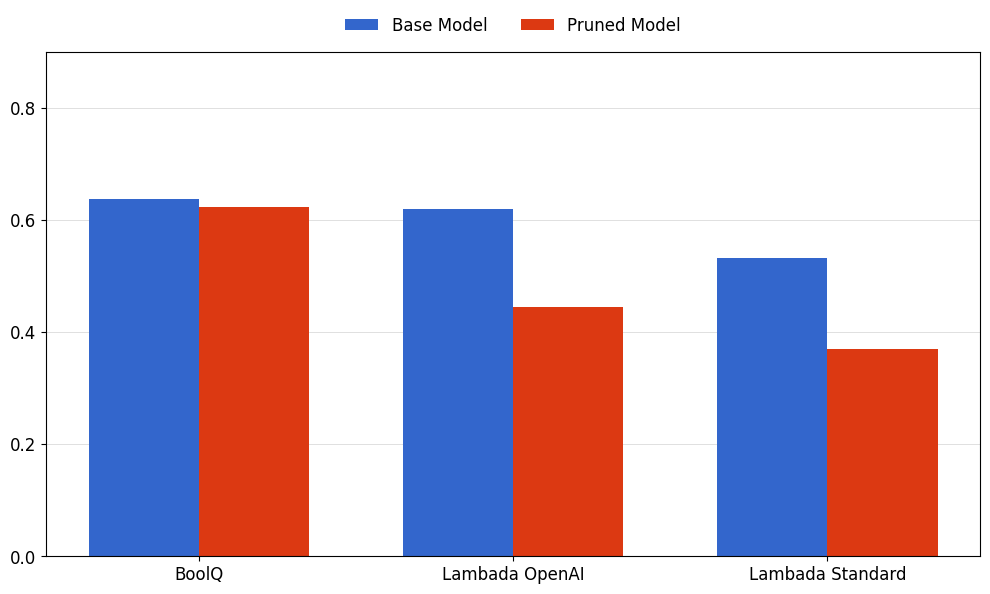

In [41]:
plot_model_comparison(metrics_base, metrics_pruned)

As we can see this Hybrid Pruning system in which we use both static data and activation-based data to decide which neurons to keep produces a very high quality model.

If we compare it with the data obtained by the model pruned only using the static data from the `gate_proj` and `up_proj` layers [(6_3_pruning_structured_llama3.2-1b_OK.ipynb)](https://github.com/peremartra/Large-Language-Model-Notebooks-Course/blob/main/6-PRUNING/6_3_pruning_structured_llama3.2-1b_OK.ipynb) the quality improvement in the Lambada benchmarks is remarkable.

| Model | BoolQ | Lambada OpenAI | Lambada Standard |
|---|---|---|---|
| Base.  | 0.637 | 0.619 | 0.532 |
| Pruning Hybrid | 0.622 | 0.445 | 0.370  |
| Pruning Static | 0.622 | 0.293 | 0.241  |

The method serves not only to create specialist models, but also to create generalist models using a generalist dataset such as wikitext.

##Authors Note.
In addition to creating content like this notebook and offering it under the MIT license, I have also contributed to repositories such as those of Hugging Face and Google Gemini.

I am especially proud of my book: <a href="https://hubs.la/Q040tvsK0"><b>Rearchitecting LLMs - Structural techniques for efficient models</b></a> (Manning Publications).

You can find it at Manning.

If you take a look and end up purchasing it, keep in mind that you can reach out with any questions via the Discussions section of this same repository or on any of my social media channels. I’ll do my best to respond as quickly as possible.